In [1]:
from pathlib import Path
from datetime import datetime
import sys
import yaml
from time import time
import os
import copy
from geopy.geocoders import GoogleV3, Nominatim
import matplotlib.dates as mdates
from numpy import median
import math
from shapely.geometry import Point

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import lines

DIR = Path('..')
sys.path.insert(0, str(DIR))
from SCanalyzer import SCanalyzer
from SCanalyzer.busSim import BusSim, Config
from SCanalyzer.busSim.manager import managerFactory
from SCanalyzer.gtfs_edit import edit_double
from SCanalyzer.util import findEPSG
from SCanalyzer.busSim.manager import LocalManager
from pyproj import Transformer

import matplotlib.pyplot as plt
from matplotlib import lines

import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

from shapely import geometry

%matplotlib inline

manger init
mangager register
mangager register


In [2]:
background_path = os.path.join('..', 'data', 'plot', 'background', 'stlouis')
city = gpd.read_file(os.path.join(background_path, "Cities.zip")).to_crs(4326)
# lakes = gpd.read_file(os.path.join(background_path, "Rivers.zip")).to_crs(4326)
# street = gpd.read_file(os.path.join(background_path, "Roads.zip")).to_crs(4326)
max_lon = city.bounds.maxx.max()
min_lon = city.bounds.minx.min()
max_lat = city.bounds.maxy.max()
min_lat = city.bounds.miny.min()

In [3]:
def get_sigmoid(x):
    return 1/(1+math.e**(-x))-0.5

def get_score(area, banks=0, clinics=0, dentists=0, hospitals=0, supermarkets=0):
    # y = sqrt(x), sigmoid, saturated functions
    score = get_sigmoid(banks) + get_sigmoid(clinics) + get_sigmoid(hospitals) + get_sigmoid(dentists) + get_sigmoid(supermarkets)
    return score

In [4]:
api_key = 'ZsHZFGtKEZeOOXhTne98eErmfd6BfNTm9GqO2S6inSnWzDwtgC2sEauXcB-8zUna_lXZEal4jsW_St6O0OQOcuNvifrr6uqNYmjFXW-FyVKvaMyczbihWELI80tjYHYx'
gtfo = SCanalyzer(os.path.join('..', 'data', 'stlouis_gtfs.zip'))
census_gdf = gtfo.load_census()
services_gdf = gtfo.load_yelp(api_key=api_key)

stops_meter exists


In [5]:
temp_df = services_gdf.apply(copy.deepcopy)

epsg = findEPSG(temp_df['latitude'].iloc[0], temp_df['longitude'].iloc[0])
transformer = Transformer.from_crs(4326, epsg)
stop_x, stop_y = transformer.transform(
            temp_df['latitude'], temp_df['longitude'])
temp_df['stop_x'], temp_df['stop_y'] = stop_x, stop_y

In [6]:
# the number of each building in each census block
city = city.to_crs(epsg)

new_census = census_gdf.to_crs(epsg).intersection(city.unary_union)
census_union = gpd.GeoDataFrame(geometry=new_census, crs=epsg)
# census_union = pd.concat([census_union, new_census.iloc[:, -5:]], axis=1)
new_census = census_union[~census_union['geometry'].is_empty].copy(True)
new_census['banks'] = 0
new_census['clinics'] = 0
new_census['dentists'] = 0
new_census['hospitals'] = 0
new_census['supermarket'] = 0
for idx, row in new_census.iterrows():
    for _, service in temp_df.iterrows():
        # if row['miny'] <= service['latitude'] <= row['maxy'] and row['minx'] <= service['longitude'] <= row['maxx']:
        if row.geometry.contains(Point(service.stop_x, service.stop_y)):
            new_census.loc[idx, service['service']] += 1

In [7]:
new_census['score'] = 0
for idx, row in new_census.iterrows():
    new_census.loc[idx, 'score'] = get_score(0, row['banks'], row['clinics'], row['dentists'], row['hospitals'], row['supermarket'])

In [8]:
new_census = new_census.to_crs(4326).copy(True)

In [9]:
polys = [(min_lon, min_lat), (min_lon, max_lat), (max_lon, min_lat), (max_lon, max_lat)]
s = gpd.GeoSeries(geometry.Polygon(polys).convex_hull)
res = new_census.apply(lambda row: s.contains(row['geometry'].centroid), axis=1)
new_census = new_census[res[0]]
# s.contains(new_census.centroid)

In [10]:
new_census_sorted = new_census[new_census['score'] != 0].sort_values('score')
points_low = new_census_sorted.head(10)
points_high = new_census_sorted.tail(10)
points = {"low": [(p.y, p.x) for p in points_low.centroid],
    "high": [(p.y, p.x) for p in points_high.centroid]}

<ipython-input-10-5953e23ada9c>:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  points = {"low": [(p.y, p.x) for p in points_low.centroid],
<ipython-input-10-5953e23ada9c>:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  "high": [(p.y, p.x) for p in points_high.centroid]}


In [17]:
points_high

,geometry,banks,clinics,dentists,hospitals,supermarket,score
775,"POLYGON ((-90.29160 38.59314, -90.29145 38.594...",1,2,0,2,0,0.992653
528,"POLYGON ((-90.30693 38.59287, -90.30205 38.592...",2,1,6,0,0,1.109383
1168,"POLYGON ((-90.29616 38.59359, -90.29160 38.593...",2,1,6,0,0,1.109383
338,"POLYGON ((-90.26450 38.62875, -90.26498 38.625...",0,3,1,3,0,1.136207
1619,"POLYGON ((-90.26317 38.63477, -90.26260 38.637...",4,1,0,3,0,1.165646
1006,"POLYGON ((-90.25520 38.63889, -90.25154 38.638...",1,2,1,2,0,1.223711
133,"POLYGON ((-90.25794 38.64245, -90.25422 38.641...",1,1,2,1,1,1.305031
784,"POLYGON ((-90.26479 38.64391, -90.26480 38.644...",3,5,0,10,0,1.445836
318,"POLYGON ((-90.29101 38.59652, -90.29145 38.594...",4,2,3,1,0,1.546444
1424,"POLYGON ((-90.19726 38.63051, -90.19670 38.631...",12,2,5,1,1,1.836215


In [11]:
def flatten(s, crs):
    return gpd.GeoDataFrame({"geometry": gpd.GeoSeries([s.unary_union]), 'crs': crs})

def gen_busSim(data_path=None, out_path=None, day=None, start_time=None, elapse_time=None, avg_walking_speed=None, max_walking_min=None):
    manager = LocalManager(data_path, out_path, None)
    busSim = BusSim(manager, day, start_time, elapse_time, avg_walking_speed, max_walking_min)
    return busSim

def get_area(start_points=[], start_locations=[], busSim=None, crs=None, city=None):
    if len(start_points)==0:
        geolocator = Nominatim(user_agent="user_test")
        for loc in start_locations:
            location = geolocator.geocode(loc)
            print(location)
            start_point = (location.latitude, location.longitude)
            start_points.append(start_point)
    
    area_dict = {}
    # print(f'{start_points=}')
    for index, start in enumerate(start_points):
        # print(f'{start=}')
        gdf = busSim.get_gdf(start_point=start)
        busSim.clear_graph()
        if gdf is None:
            area_dict[f'{start_points[index]}'] = 0
            continue
        gdf = gdf.to_crs(epsg=crs)
        bubble = flatten(gdf.geometry, crs)
        new_census2 = new_census.to_crs(crs).intersection(bubble.unary_union)
        new_census2 = gpd.GeoDataFrame(geometry=new_census2, crs=crs)
        new_census2['score'] = new_census['score']
        # print(f'{new_census2.head()=}')
        area_dict[f'{start_points[index]}'] = new_census2[~new_census2['geometry'].is_empty]['score'].sum()
    # print(f'{area_dict=}')
    return area_dict

def draw_area_times(times, areas, data_path, results):
    fig, ax = plt.subplots(figsize=(12,8)) 
    times = list(map(lambda x: datetime.strptime(x.capitalize(), "%A %H:%M:%S  %d"), times))
    formatter = mdates.DateFormatter("%a %H:%M")
    plt.gca().xaxis.set_major_formatter(formatter)
    plt.gcf().autofmt_xdate()
    
    for key in areas.keys():
        # print(f'loc {key}')
        # print(f'{areas[key]=}')
        # print(f'min value: {min(areas[key])}')
        results['min score'].append(min(areas[key]))
        results['max score'].append(max(areas[key]))
        results['median score'].append(median(areas[key]))
        # print(f'max value: {max(areas[key])}')
        geoloctor = Nominatim(user_agent="reverse_user")
        info = geoloctor.reverse(key[1:-1]).raw
        if info != None:
            info = info['address']
            addr = ''
            for index, addrkey in enumerate(info):
                if index > 1:
                    break
                addr += " " + info[addrkey]
        else:
            addr = key
        ax.plot(times, areas[key], label = addr)
        results['label'].append(addr)
    
    ax.set_ylim(bottom=0)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Time', fontsize=18)
    plt.ylabel("score", fontsize=18)
    plt.title('Score vs Time', fontsize=20)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.savefig('mearsurement_plot.png', bbox_inches='tight')

def run(start_times, DATA_PATH, OUT_PATH, ELAPSE_TIME, AVG_WALKING_SPEED, MAX_WALKING_MIN, START_POINTS, START_LOCATIONS, crs, results):
    prog_start = time()
    areas = {}
    for start_time in start_times:
        # print('creat busSim')
        day, start = start_time.split(' ')
        busSim = gen_busSim(DATA_PATH,OUT_PATH, day, start, ELAPSE_TIME, AVG_WALKING_SPEED, MAX_WALKING_MIN)
        # print('cal area')
        for key, area in get_area(start_points=START_POINTS, start_locations=START_LOCATIONS, busSim=busSim, crs=crs).items():
            if key not in areas:
                areas[key] = []
                areas[key].append(float(area))
            else:
                areas[key].append(float(area))
    # print(f'{areas=}')
    pre_day = ''
    day_index = 0
    for index in range(len(start_times)):
        day, start = start_times[index].split(' ')
        if pre_day != day:
            day_index+=1
            pre_day = day
        start_times[index] = f"{start_times[index]}  {day_index}"
        
    print(start_times)
    draw_area_times(start_times, areas, DATA_PATH, results)
    duration = time() - prog_start
    # results['time'].append(duration)
    print(f'time taken {duration}')
    return duration

len(start_points_dict["low"])=10
stops_meter exists
['monday 00:00:00  1', 'monday 03:00:00  1', 'monday 06:00:00  1', 'monday 09:00:00  1', 'monday 12:00:00  1', 'monday 15:00:00  1', 'monday 18:00:00  1', 'monday 21:00:00  1', 'tuesday 00:00:00  2', 'tuesday 03:00:00  2', 'tuesday 06:00:00  2', 'tuesday 09:00:00  2', 'tuesday 12:00:00  2', 'tuesday 15:00:00  2', 'tuesday 18:00:00  2', 'tuesday 21:00:00  2', 'wednesday 00:00:00  3', 'wednesday 03:00:00  3', 'wednesday 06:00:00  3', 'wednesday 09:00:00  3', 'wednesday 12:00:00  3', 'wednesday 15:00:00  3', 'wednesday 18:00:00  3', 'wednesday 21:00:00  3', 'thursday 00:00:00  4', 'thursday 03:00:00  4', 'thursday 06:00:00  4', 'thursday 09:00:00  4', 'thursday 12:00:00  4', 'thursday 15:00:00  4', 'thursday 18:00:00  4', 'thursday 21:00:00  4', 'friday 00:00:00  5', 'friday 03:00:00  5', 'friday 06:00:00  5', 'friday 09:00:00  5', 'friday 12:00:00  5', 'friday 15:00:00  5', 'friday 18:00:00  5', 'friday 21:00:00  5', 'saturday 00:00:00 

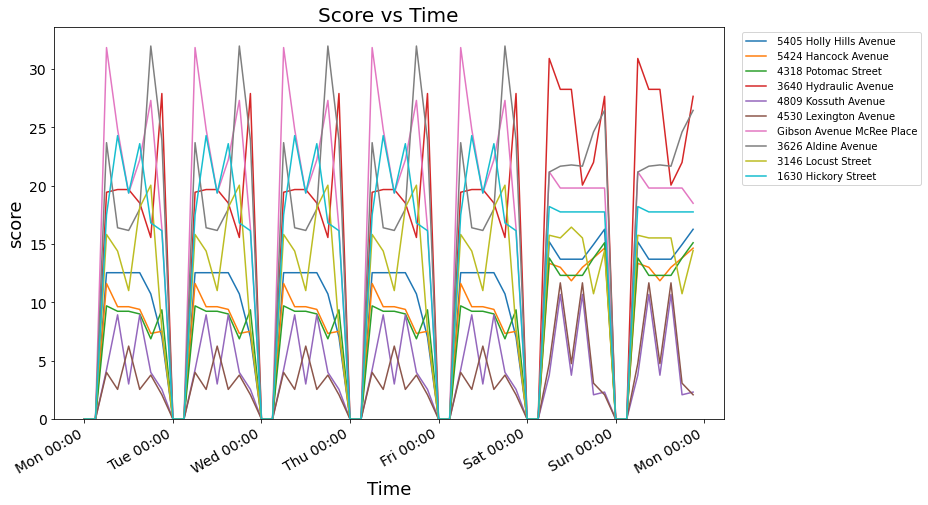

In [12]:
start_points_dict = points

results = {
    "label":[],
    "max score": [],
    "min score": [],
    "median score": []
}

print(f'{len(start_points_dict["low"])=}')
START_POINTS = start_points_dict['low']
ELAPSE_TIME = "00:30:00"
AVG_WALKING_SPEED = 1.4 # 1.4 meters per second
MAX_WALKING_MIN = 12

DATA_PATH = "../data/stlouis_gtfs.zip"
OUT_PATH = "/tmp/output" 
sc = SCanalyzer(DATA_PATH)
crs = 3174
START_LOCATIONS = []

runs = []
start_times = []
days = ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]
# days = ["monday"]
for day in days:
    for start_time in range(0,24,3):
        start_times.append('{} {:02}:{:02}:{:02}'.format(day, start_time, 0, 0))    
runs.append(run(start_times, DATA_PATH, OUT_PATH, ELAPSE_TIME, AVG_WALKING_SPEED, MAX_WALKING_MIN, START_POINTS, START_LOCATIONS, crs, results))

In [13]:
print(pd.DataFrame(results).to_markdown())

|    | label                     |   max score |   min score |   median score |
|---:|:--------------------------|------------:|------------:|---------------:|
|  0 | 5405 Holly Hills Avenue   |     16.2578 |           0 |       12.5369  |
|  1 | 5424 Hancock Avenue       |     14.6404 |           0 |        9.39296 |
|  2 | 4318 Potomac Street       |     15.1025 |           0 |        9.23367 |
|  3 | 3640 Hydraulic Avenue     |     30.8899 |           0 |       19.4305  |
|  4 | 4809 Kossuth Avenue       |     10.6761 |           0 |        3.38009 |
|  5 | 4530 Lexington Avenue     |     11.6687 |           0 |        2.54164 |
|  6 | Gibson Avenue McRee Place |     31.8228 |           0 |       19.7903  |
|  7 | 3626 Aldine Avenue        |     31.9559 |           0 |       17.9834  |
|  8 | 3146 Locust Street        |     20.0343 |           0 |       14.3896  |
|  9 | 1630 Hickory Street       |     24.2817 |           0 |       17.4926  |


len(start_points_dict["high"])=10
stops_meter exists
['monday 00:00:00  1', 'monday 03:00:00  1', 'monday 06:00:00  1', 'monday 09:00:00  1', 'monday 12:00:00  1', 'monday 15:00:00  1', 'monday 18:00:00  1', 'monday 21:00:00  1', 'tuesday 00:00:00  2', 'tuesday 03:00:00  2', 'tuesday 06:00:00  2', 'tuesday 09:00:00  2', 'tuesday 12:00:00  2', 'tuesday 15:00:00  2', 'tuesday 18:00:00  2', 'tuesday 21:00:00  2', 'wednesday 00:00:00  3', 'wednesday 03:00:00  3', 'wednesday 06:00:00  3', 'wednesday 09:00:00  3', 'wednesday 12:00:00  3', 'wednesday 15:00:00  3', 'wednesday 18:00:00  3', 'wednesday 21:00:00  3', 'thursday 00:00:00  4', 'thursday 03:00:00  4', 'thursday 06:00:00  4', 'thursday 09:00:00  4', 'thursday 12:00:00  4', 'thursday 15:00:00  4', 'thursday 18:00:00  4', 'thursday 21:00:00  4', 'friday 00:00:00  5', 'friday 03:00:00  5', 'friday 06:00:00  5', 'friday 09:00:00  5', 'friday 12:00:00  5', 'friday 15:00:00  5', 'friday 18:00:00  5', 'friday 21:00:00  5', 'saturday 00:00:00

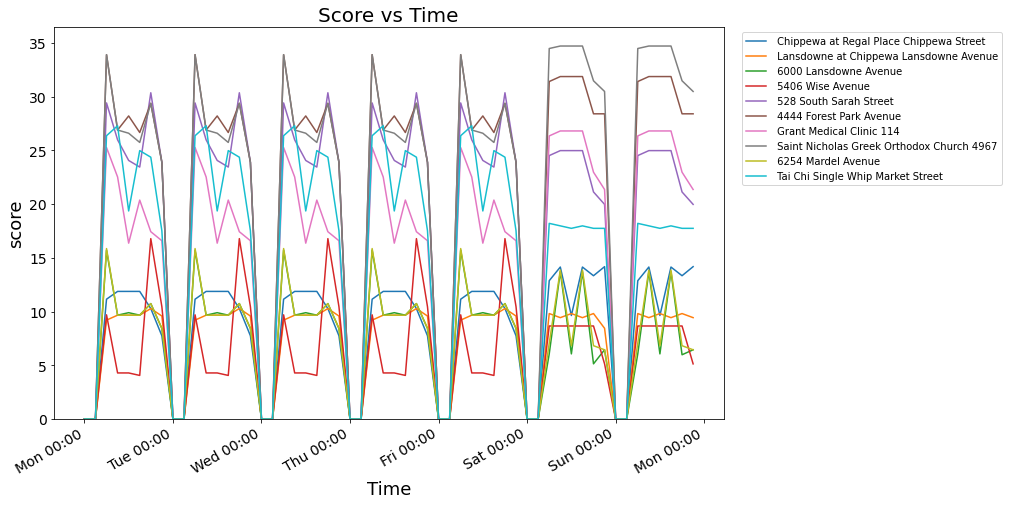

In [14]:
start_points_dict = points

results = {
    "label":[],
    "max score": [],
    "min score": [],
    "median score": []
}

print(f'{len(start_points_dict["high"])=}')
START_POINTS = start_points_dict['high']
ELAPSE_TIME = "00:30:00"
AVG_WALKING_SPEED = 1.4 # 1.4 meters per second
MAX_WALKING_MIN = 12

DATA_PATH = "../data/stlouis_gtfs.zip"
OUT_PATH = "/tmp/output" 
sc = SCanalyzer(DATA_PATH)
crs = 3174
START_LOCATIONS = []

runs = []
start_times = []
days = ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]
# days = ["monday"]
for day in days:
    for start_time in range(0,24,3):
        start_times.append('{} {:02}:{:02}:{:02}'.format(day, start_time, 0, 0))    
runs.append(run(start_times, DATA_PATH, OUT_PATH, ELAPSE_TIME, AVG_WALKING_SPEED, MAX_WALKING_MIN, START_POINTS, START_LOCATIONS, crs, results))

In [15]:
print(pd.DataFrame(results).to_markdown())

|    | label                                     |   max score |   min score |   median score |
|---:|:------------------------------------------|------------:|------------:|---------------:|
|  0 | Chippewa at Regal Place Chippewa Street   |     14.1783 |           0 |       11.1506  |
|  1 | Lansdowne at Chippewa Lansdowne Avenue    |     10.2808 |           0 |        9.58429 |
|  2 | 6000 Lansdowne Avenue                     |     15.7129 |           0 |        9.66561 |
|  3 | 5406 Wise Avenue                          |     16.7857 |           0 |        4.28971 |
|  4 | 528 South Sarah Street                    |     30.3576 |           0 |       23.9757  |
|  5 | 4444 Forest Park Avenue                   |     33.9023 |           0 |       26.8917  |
|  6 | Grant Medical Clinic 114                  |     26.8042 |           0 |       17.4304  |
|  7 | Saint Nicholas Greek Orthodox Church 4967 |     34.7062 |           0 |       26.5922  |
|  8 | 6254 Mardel Avenue               